In [1]:
import torch
import numpy as np
# import cv2
import matplotlib.pylab as plt

print(f"torch version:{torch.__version__}, cuda version:{torch.version.cuda}, cuda is available:{torch.cuda.is_available()}")

SplitLine = "\n==============================\n"

def PrintTensor(name:str, x:torch.Tensor):
    print(f"{name}:\n", x)
    print(f"{name}的维度数(秩):{x.dim()}; 形状:{x.shape}; 所在设备:{x.device}; 元素个数:{x.numel()}; 元素类型:{x.dtype}, 元素的字节大小:{x.element_size()}", end=SplitLine)

torch version:1.12.1+cu113, cuda version:11.3, cuda is available:True


### 逻辑回归 (Logistic Regression)
逻辑回归是线性的二分类模型。模型表达式 $y=f(z)=\frac{1}{1+e^{-z}}$，其中 $z=WX+b$。$f(z)$ 称为 sigmoid 函数，也被称为 Logistic 函数。       
函数曲线如下：(横坐标是 $z$，而 $z=WX+b$，纵坐标是 $y$)     
![](./assets/logistic-Regression.png)       

分类原则如下：当 $y<0.5$ 时，类别为 0；当 $0.5 \leq y$ 时，类别为 1。        
其中 $z=WX+b$ 就是原来的线性回归的模型。从横坐标来看，当 $z<0$ 时，类别为 0；当 $0 \leq z$ 时，类别为 1，直接使用线性回归也可以进行分类。逻辑回归是在线性回归的基础上加入了一个 sigmoid 函数，这是为了更好地描述置信度，把输入映射到 (0,1) 区间中，符合概率取值。       
逻辑回归也被称为对数几率回归 $\ln \frac{y}{1-y}=W X+b$，    
几率的表达式为：$\frac{y}{1-y}$，$y$ 表示正类别的概率，$1-y$ 表示另一个类别的概率。 
根据对数几率回归可以推导出逻辑回归表达式：  
$\ln \frac{y}{1-y}=W X+b$   
$\frac{y}{1-y}=e^{W X+b}$   
$y=e^{W X+b}-y * e^{W X+b}$   
$y\left(1+e^{W X+b}\right)=e^{W X+b}$   
$y=\frac{e^{W X+b}}{1+e^{W X+b}}=\frac{1}{1+e^{-(W X+b)}}$

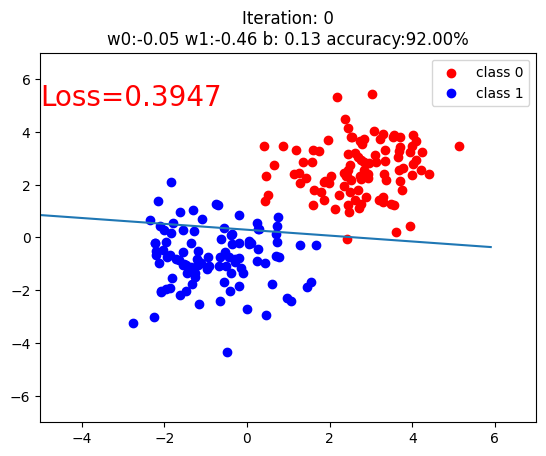

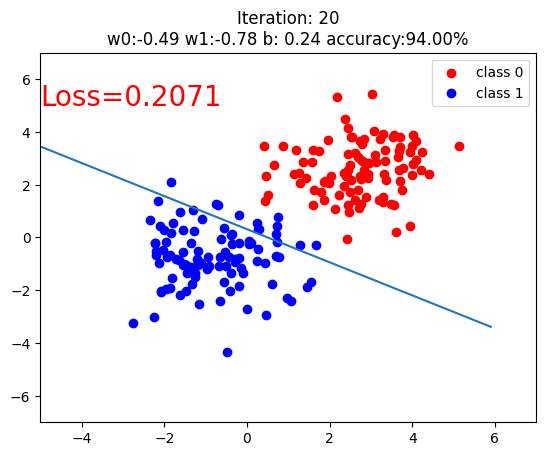

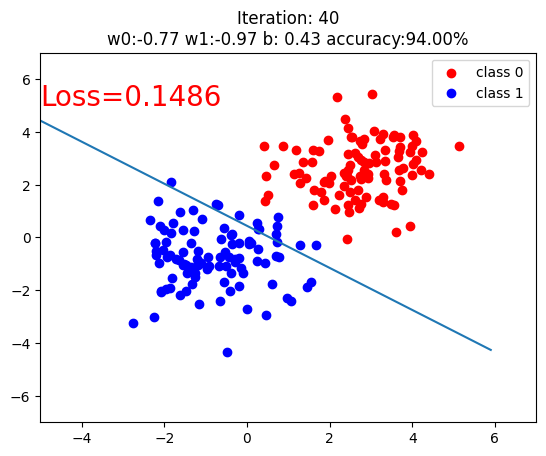

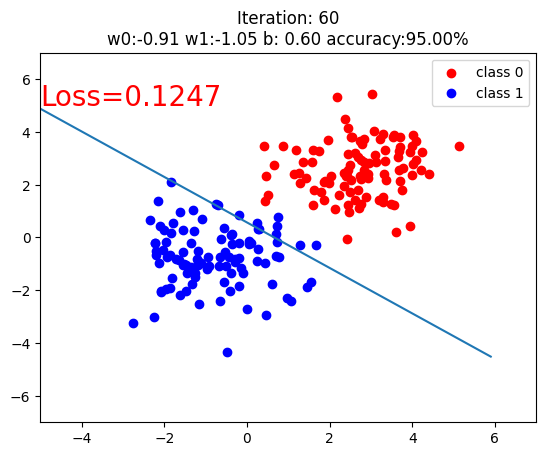

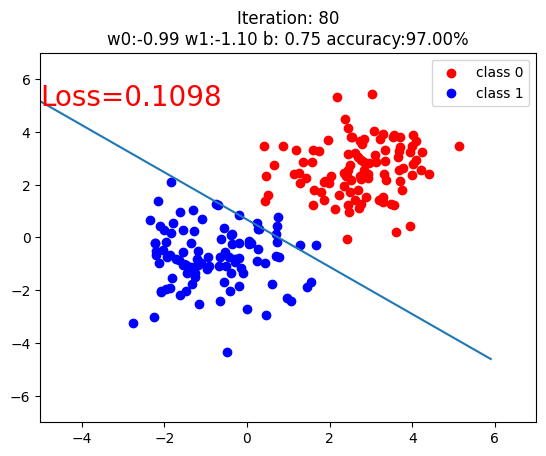

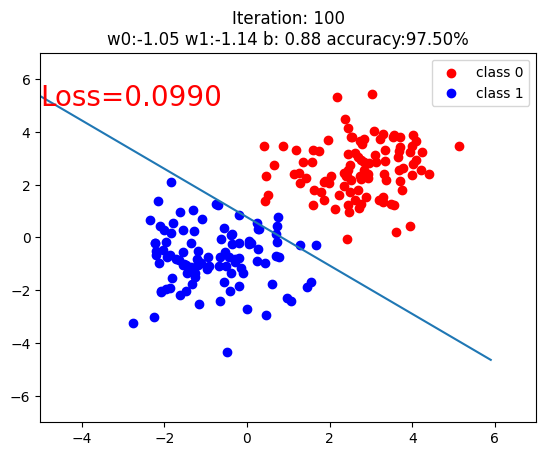

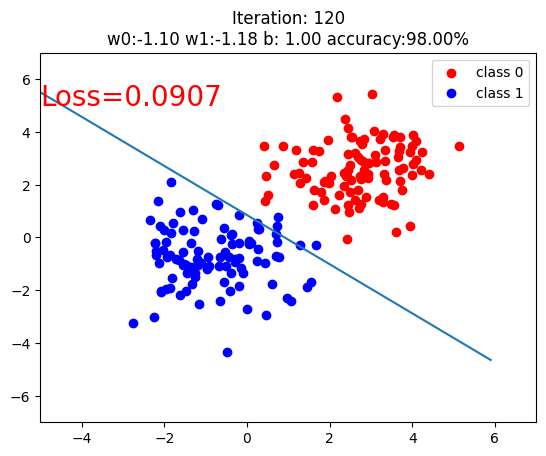

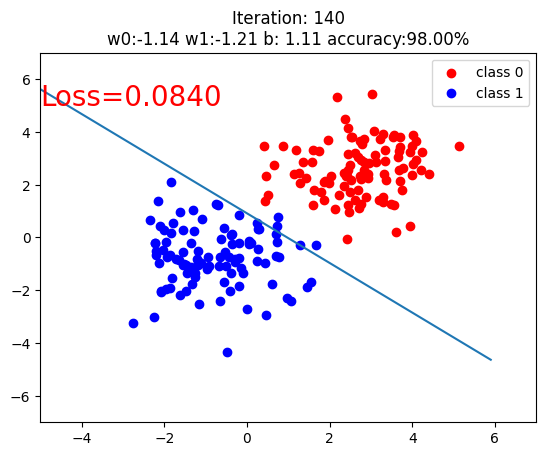

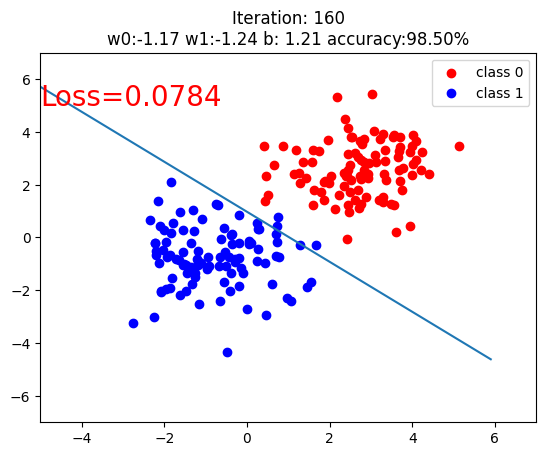

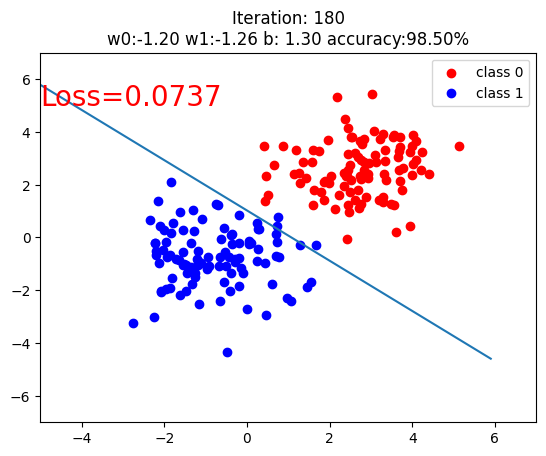

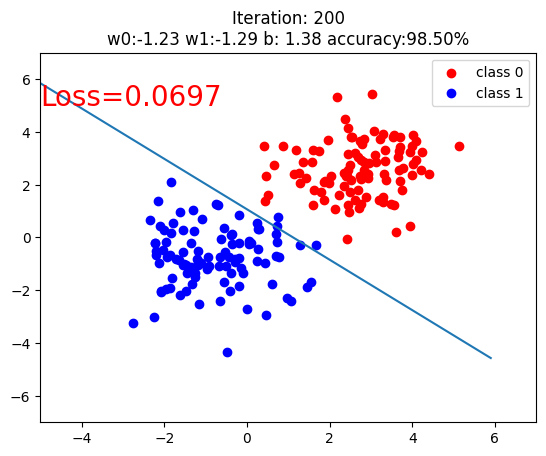

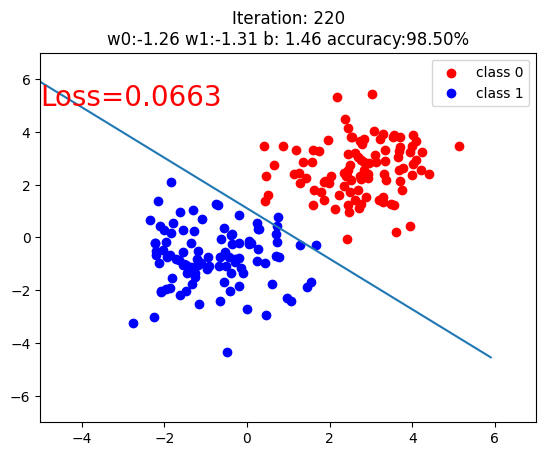

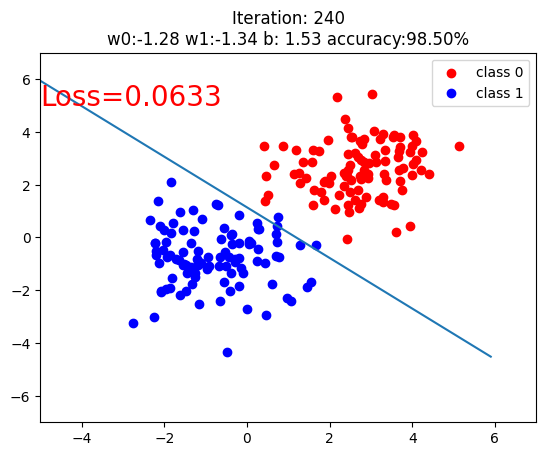

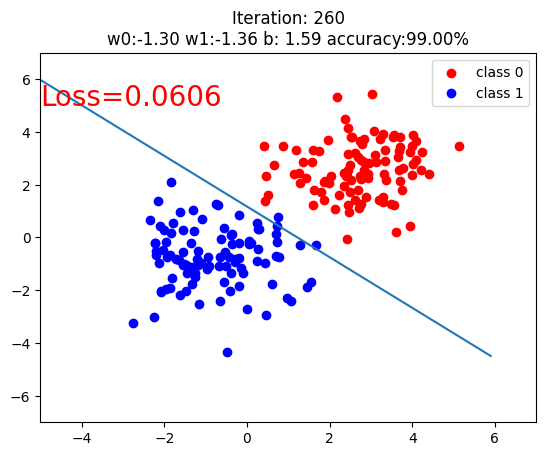

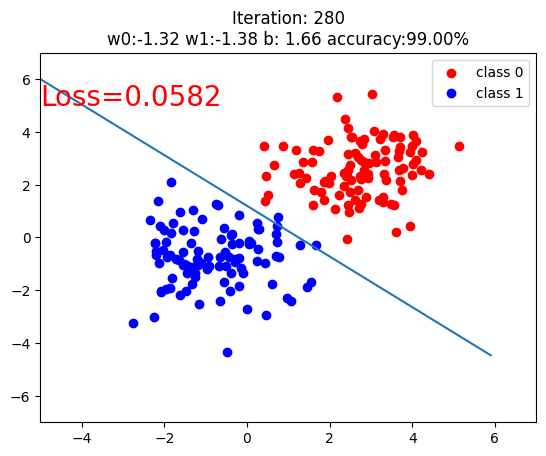

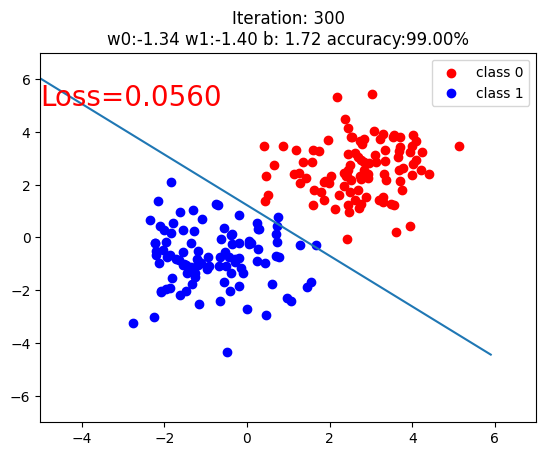

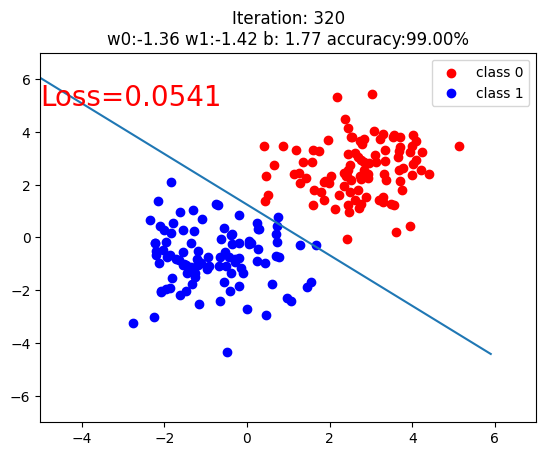

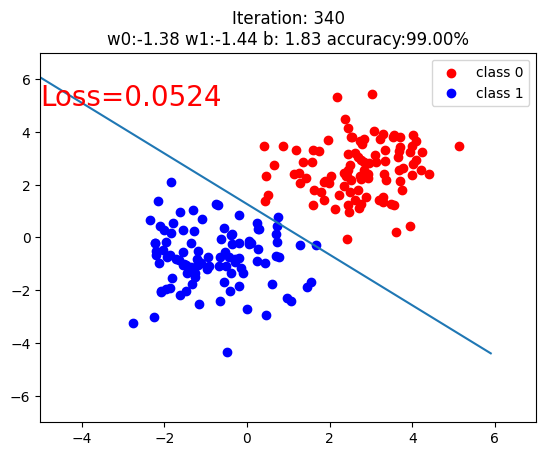

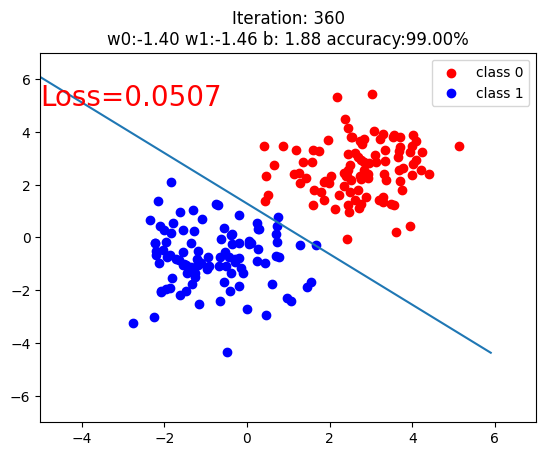

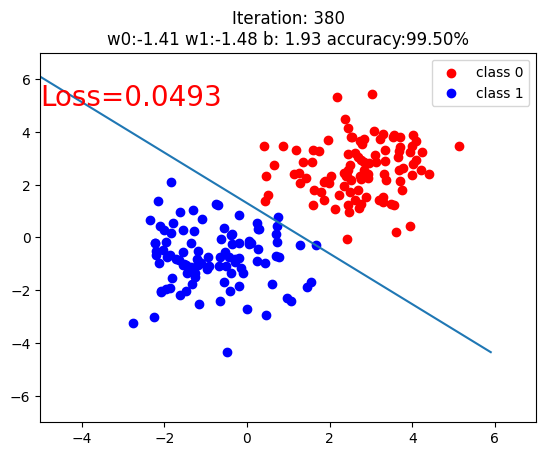

In [2]:
import torch.nn as nn


torch.manual_seed(10)
# ============================ step 1/5 生成数据 ============================
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums, 2)
# 使用正态分布随机生成样本，均值为张量，方差为标量
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2)
# 生成对应标签
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100, 1)
# 使用正态分布随机生成样本，均值为张量，方差为标量
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2)
# 生成对应标签
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100, 1)
train_x = torch.cat((x0, x1), 0)
train_y = torch.cat((y0, y1), 0)

# ============================ step 2/5 选择模型 ============================
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x

lr_net = LR()   # 实例化逻辑回归模型

# ============================ step 3/5 选择损失函数 ============================
loss_fn = nn.BCELoss()

# ============================ step 4/5 选择优化器   ============================
lr = 0.01  # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

# ============================ step 5/5 模型训练 ============================
for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)
    # 计算 loss
    loss = loss_fn(y_pred.squeeze(), train_y)
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    # 清空梯度
    optimizer.zero_grad()
    # 绘图
    if iteration % 20 == 0:
        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()
        # plt.savefig(str(iteration / 20)+".png")
        plt.show()
        plt.pause(0.5)
        # 如果准确率大于 99%，则停止训练
        if acc > 0.99:
            break


### 网络模型参数查看

1. 查看网络结构

In [18]:
print("net struct:\n", lr_net, end=SplitLine)

net struct:
 LR(
  (features): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [34]:
from torchsummary import summary
summary(lr_net, input_size=(200, 2),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 200, 1]               3
           Sigmoid-2               [-1, 200, 1]               0
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


2. 网络参数查看

In [19]:
for layer_name, param in lr_net.named_parameters():
    print(f"{layer_name}\n:", param, end=SplitLine)

features.weight
: Parameter containing:
tensor([[-1.4139, -1.4769]], requires_grad=True)
features.bias
: Parameter containing:
tensor([1.9262], requires_grad=True)


In [30]:
for param in lr_net.parameters():
    print(f"param:\n", param, end=SplitLine)

param:
 Parameter containing:
tensor([[-1.4139, -1.4769]], requires_grad=True)
param:
 Parameter containing:
tensor([1.9262], requires_grad=True)


3. 权重查看

In [20]:
feas =  lr_net.features.weight[0]
PrintTensor("feas", feas)
feas_bias = lr_net.features.bias[0]
PrintTensor("feas_bias", feas_bias)

feas:
 tensor([-1.4139, -1.4769], grad_fn=<SelectBackward0>)
feas的维度数(秩):1; 形状:torch.Size([2]); 所在设备:cpu; 元素个数:2; 元素类型:torch.float32, 元素的字节大小:4
feas_bias:
 tensor(1.9262, grad_fn=<SelectBackward0>)
feas_bias的维度数(秩):0; 形状:torch.Size([]); 所在设备:cpu; 元素个数:1; 元素类型:torch.float32, 元素的字节大小:4


In [28]:
for item_key in lr_net.state_dict().keys():
    print(f"key: {item_key}", end=SplitLine)

for item_value in lr_net.state_dict().values():
    print(f"value: {item_value}", end=SplitLine)

for item_key, item_value in lr_net.state_dict().items():
    print(f"key: {item_key}\nvalue:\n", item_value, end=SplitLine)

key: features.weight
key: features.bias
value: tensor([[-1.4139, -1.4769]])
value: tensor([1.9262])
key: features.weight
value:
 tensor([[-1.4139, -1.4769]])
key: features.bias
value:
 tensor([1.9262])


* 查看梯度

In [42]:
PrintTensor("features weights", lr_net.features.weight)
print(lr_net.features.weight.grad)
print(lr_net.features.weight.requires_grad, end=SplitLine)
# weight 梯度中的切片，requires_grad为False
print(lr_net.features.weight.grad[0])
print(lr_net.features.weight.grad[0].requires_grad)
print(lr_net.features.weight.grad[0][0])
print(lr_net.features.weight.grad[0][0].requires_grad)

features weights:
 Parameter containing:
tensor([[-1.4139, -1.4769]], requires_grad=True)
features weights的维度数(秩):2; 形状:torch.Size([1, 2]); 所在设备:cpu; 元素个数:2; 元素类型:torch.float32, 元素的字节大小:4
tensor([[0., 0.]])
True
tensor([0., 0.])
False
tensor(0.)
False
